In [1]:
using LinearAlgebra
using Distributions
using Plots
using ColorSchemes

## Parametros de error instrumentos

Δt = 0.1

fs = 10
fs2 = 1
PSD_a = 80*10*1e-6
PSD_g = 0.03*π/180
PSD_m = 100e-6*1e-4
B_T = 25358e-9

err_IMU_x = PSD_a*sqrt(fs)
err_IMU_θ = PSD_g*sqrt(fs)

err_GPS = 2.5
err_MAG = PSD_m*sqrt(fs2)/B_T

Q = [err_IMU_x^2 0 0; 0 err_IMU_x^2 0; 0 0 err_IMU_θ^2]

R = [err_GPS^2 0 0; 0 err_GPS^2 0; 0 0 err_MAG^2]

dist_ruido_IMU = MvNormal([0,0,0], Q)
dist_ruido_GPS = MvNormal([0,0,0], R)


println(Q)
println(R)

[6.4000000000000006e-6 0.0 0.0; 0.0 6.4000000000000006e-6 0.0; 0.0 0.0 2.7415567780803773e-6]
[6.25 0.0 0.0; 0.0 6.25 0.0; 0.0 0.0 1.5551418366801118e-7]


In [2]:
# Generadores de datos 

function estatico_IMU()
    return [0,0,0]
end
function estatico_GPS()
    return [0,0,0]
end

estatico_GPS (generic function with 1 method)

In [3]:
## Matrices filtro Kalman

A = [1 Δt 0 0 0;
     0 1 0 0 0;
     0 0 1 Δt 0;
     0 0 0 1 0;
     0 0 0 0 1]

function B_matrix(θ)
    return [Δt^2*cos(θ)/2 -Δt^2*sin(θ)/2 0;
    Δt*cos(θ) -Δt*sin(θ) 0;
    Δt^2*sin(θ)/2 Δt^2*cos(θ)/2 0;
    Δt*sin(θ) Δt*cos(θ) 0;
    0 0 Δt]
end

H = [1 0 0 0 0;
     0 0 1 0 0;
     0 0 0 0 1]

3×5 Matrix{Int64}:
 1  0  0  0  0
 0  0  1  0  0
 0  0  0  0  1

In [4]:
function kalman_predict(x, u, P)
    B = B_matrix(x[5])
    x_est = A*x + B*u
    P_est = A*P*A' + B*Q*B'
    K = P_est*H'*inv(H*P_est*H'+R)
    return x_est, P_est, K
end

function kalman_correct(x_prior, z, P_prior, K)
    x_est = x_prior + K*(z-H*x_prior)
    P_est = (I-K*H)*P_prior
    return x_est, P_est
end

function kalman_initialize(t, z)
    N = length(t)
    x = zeros(5, N)
    x[1:2:5,1] = z[:,1]
    P = zeros(5, 5, N)
    P[:,:,1] = diagm([err_GPS^2,(err_GPS*fs2)^2,err_GPS^2,(err_GPS*fs2)^2,2pi])
    K = zeros(5, 3, N)
    return x, P, K
end

function kalman(t, tasa_GPS, u, z)
    x, P, K = kalman_initialize(t, z)
    for k in 2:length(t)
        x_est, P_est, K_k = kalman_predict(x[:,k-1], u[:,k], P[:,:,k-1])
        if k%tasa_GPS == 0
            x_est, P_est = kalman_correct(x_est, z[:,k], P_est, K_k)
        end
        x[:,k] = x_est
        P[:,:,k] = P_est
        K[:,:,k] = K_k
    end
    return x, P, K
end

kalman (generic function with 1 method)

In [5]:
T = 500
t = 0:0.1:T

u_true = hcat([estatico_IMU() for ti in t]...)
u_noise = hcat([rand(dist_ruido_IMU) for ti in t]...)
z_true = hcat([estatico_GPS() for ti in t]...)
z_noise = hcat([rand(dist_ruido_GPS) for ti in t]...)
u = u_true + u_noise
z = z_true + z_noise
x, P, K = kalman(t, 10, u, z)

([-3.437172170088852 -3.437170067606941 … -0.05514864048733337 -0.0549463982529141; 0.0 4.2049638219432486e-5 … 0.002251057155687055 0.0017937875326982514; … ; 0.0 0.0002790696015042668 … 0.008183487598527939 0.007421000771058218; -0.0004533360878956477 -0.0007231607468178242 … -0.0005320521099213215 -0.0005290357290462975], [6.25 0.0 … 0.0 0.0; 0.0 6.25 … 0.0 0.0; … ; 0.0 0.0 … 6.25 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 6.31250000016 0.6250000032 … 3.0132212732029537e-29 0.0; 0.6250000032 6.250000064 … 6.026445866657267e-28 0.0; … ; 2.566549783865771e-29 -5.9232401974700555e-28 … 6.250000064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 6.5000000016 1.2500000128000002 … -2.7410752269784475e-28 0.0; 1.2500000128000002 6.250000128 … -5.071850471591023e-27 0.0; … ; 8.923795762240636e-29 2.9051123060548158e-27 … 6.250000128 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972719705013783 0.002020370544845382 … -1.740930778211156e-24 0.0; 0.002020370544845382 5.0854141278523966e-5 … -3.467292

In [6]:
println(length(t))

5001


In [7]:
function trayectoria_xy(x, z_true)
    p1 = plot(x[1,:], x[3,:], label="Estimación", xlabel="x", ylabel="y", aspect_ratio=:equal, title="Trayectoria XY")
    plot!(p1, z_true[1,:], z_true[2,:], label="Trayectoria")
    return p1
end

function trayectoria_t(t, x, z_true)
    p1 = plot(t, x[1,:], ylabel="x [m]", title="Trayectoria en función del tiempo")
    plot!(p1, t, z_true[1,:])
    p2 = plot(t, x[3,:], ylabel="y [m]")
    plot!(p2, t, z_true[2,:])
    p3 = plot(t, x[5,:] .% 2pi, ylabel="θ", xlabel="t [s]")
    plot!(p3, t, z_true[3,:] .% 2pi)
    return plot(p1,p2,p3, layout=(3,1), legend=false)
end

trayectoria_t (generic function with 1 method)

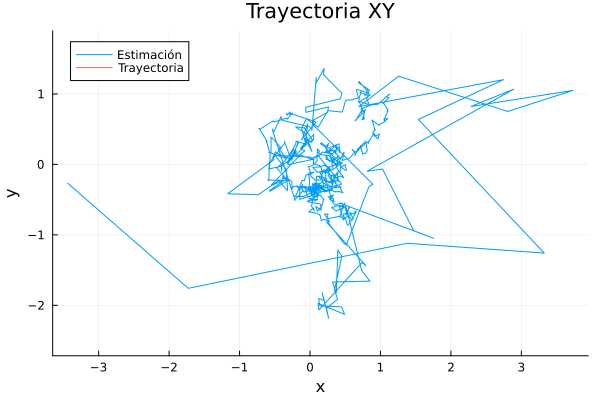

In [8]:
trayectoria_xy(x, z_true)

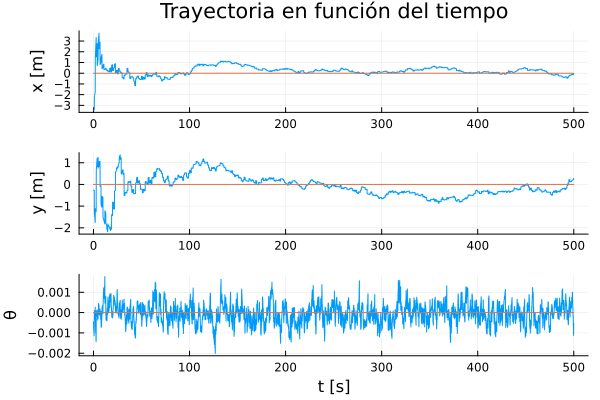

In [9]:
trayectoria_t(t, x, z_true)

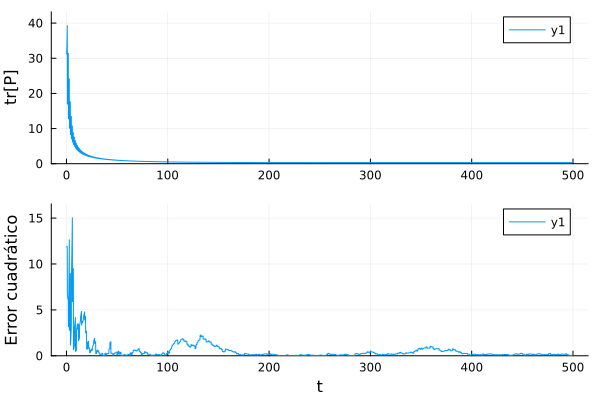

In [10]:
function varianza_estimador(P)
    return [tr(P[:,:,i]) for i in 1:size(P,3)]
end

function estimation_error(x, z_true)
    xs = [[x_i[1] x_i[3]] for x_i in eachcol(x)]
    zs = [[z_i[1] z_i[2]] for z_i in eachcol(z_true)]
    return [norm(x_i-z_i)^2 for (x_i, z_i) in zip(xs, zs)]
end

function kalman_gain(K)
    return [norm(K[:,:,i]) for i in 1:size(K,3)]
end

function plot_error(t, x, z_true, P)
    v = varianza_estimador(P)
    e = estimation_error(x, z_true)
    p1 = plot(t, v, ylim=[0, maximum(v)*1.1], ylabel="tr[P]")
    p2 = plot(t, e, ylim=[0, maximum(e)*1.1], ylabel="Error cuadrático", xlabel="t")
    return plot(p1, p2, layout=(2,1))
end


plot_error(t, x, z_true, P)

In [11]:
function plot_gain(t, P, K)
    v = varianza_estimador(P)
    k = kalman_gain(K)
    p1 = plot(t, v, ylim=[0, maximum(v)*1.1], ylabel="tr[P]")
    p2 = plot(t, k, ylim=[0, maximum(k)*1.1], ylabel="norm[K]", xlabel="t")
    return plot(p1, p2, layout=(2,1))
end

plot_gain (generic function with 1 method)

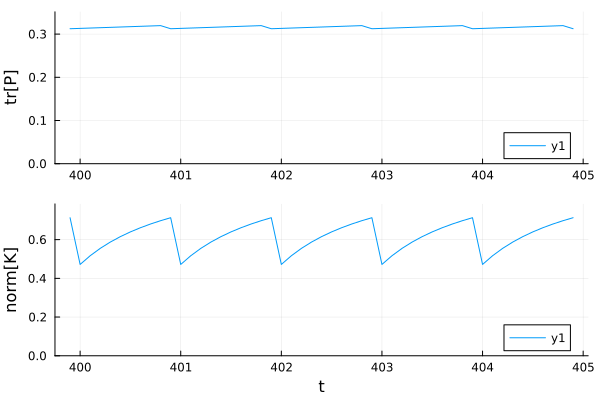

In [12]:
k1 = 4000
k2 = 4050
plot_gain(t[k1:k2], P[:,:,k1:k2], K[:,:,k1:k2])

In [13]:
# Generadores de datos 

function mru_IMU()
    return [0,0,0]
end
function mru_GPS(v, t, θ)
    return [v*t*cos(θ),v*t*sin(θ),θ]
end

mru_GPS (generic function with 1 method)

In [14]:
t_gps = t[1:10:end]

u_true = hcat([estatico_IMU() for ti in t]...)
z_true = hcat([mru_GPS(100/T, ti, pi/4) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

x, P, K = kalman(t, 10, u, z)

([-3.437172170088852 -3.4371805500100177 … 70.42753125927538 70.44163038344469; 0.0 -0.00016759842331529284 … 0.14088333111565546 0.1410991522706787; … ; 0.0 0.00022706559197809633 … 0.15198424448381923 0.15112174642630397; 0.7849448273095526 0.7846750026506304 … 0.784866111287527 0.7848691276684021], [6.25 0.0 … 0.0 0.0; 0.0 6.25 … 0.0 0.0; … ; 0.0 0.0 … 6.25 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 6.31250000016 0.6250000032 … 1.179808407269431e-25 0.0; 0.6250000032 6.250000064 … -2.885189585345663e-24 0.0; … ; 1.7781507665368613e-25 -2.442855625326188e-24 … 6.250000064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 6.5000000016 1.2500000128000002 … 1.3837028614823992e-25 0.0; 1.2500000128000002 6.250000128 … -4.978827631758677e-24 0.0; … ; 1.3698520518111092e-25 -4.288706713749247e-24 … 6.250000128 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972719705013783 0.002020370544845382 … 9.014604622213589e-22 0.0; 0.002020370544845382 5.0854141278523966e-5 … 1.3075201124897577e-23 0.0; … ; -1

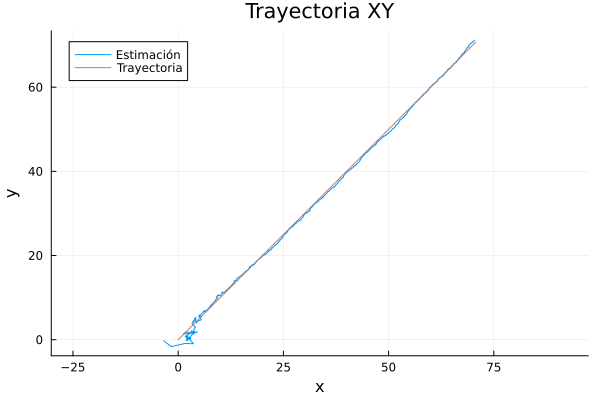

In [15]:
trayectoria_xy(x, z_true)

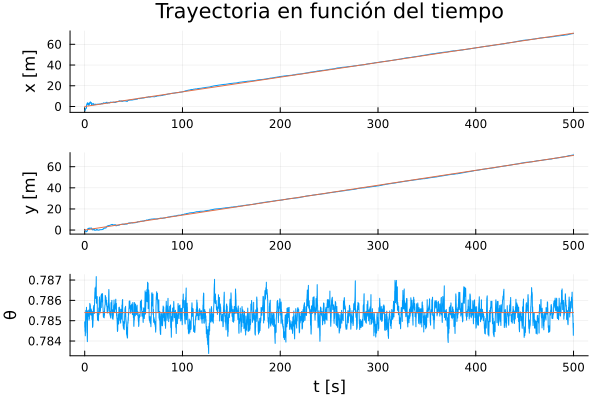

In [16]:
trayectoria_t(t, x, z_true)

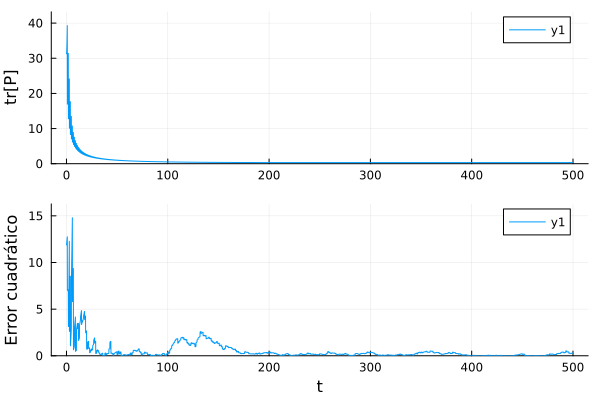

In [17]:

plot_error(t, x, z_true, P)

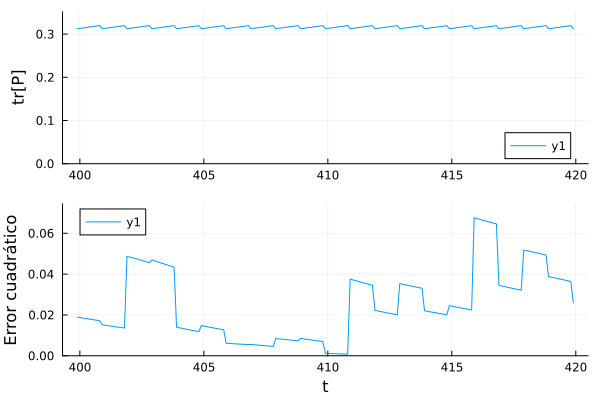

In [18]:
k1 = 4000
k2 = 4200
plot_error(t[k1:k2], x[:,k1:k2], z_true[:,k1:k2], P[:,:,k1:k2])

In [19]:
# Generadores de datos 

function circular_IMU(r, w, t)
    return [0,w^2*r,w] 
end

function circular_GPS(r, w, t)
    return [r*cos(w*t),r*sin(w*t),w*t+π/2] 
end

u_true = hcat([circular_IMU(20, 2*pi/T, ti) for ti in t]...)
z_true = hcat([circular_GPS(20, 2*pi/T, ti) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

3×5001 Matrix{Float64}:
 16.5628    19.5023   23.6845    19.03     …  22.6308    22.6504   22.8569
 -0.268929   1.18634   0.423407  -3.41143     -0.592076   2.48937   3.36965
  1.57034    1.57214   1.57367    1.57401      7.8517     7.85236   7.85422

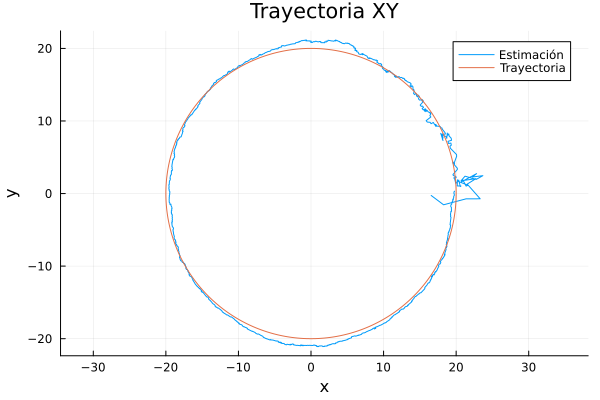

In [20]:
x, P, K = kalman(t, 10, u, z)

trayectoria_xy(x, z_true)

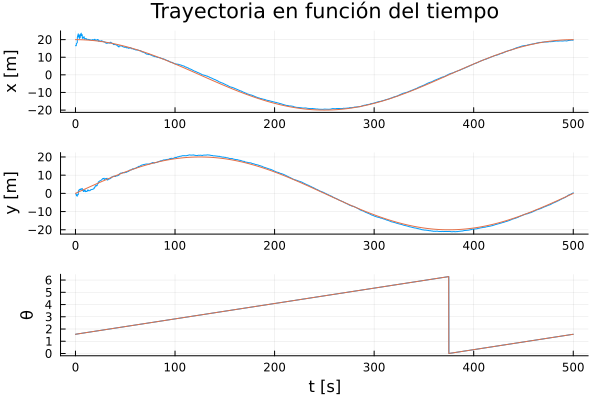

In [21]:
trayectoria_t(t, x, z_true)

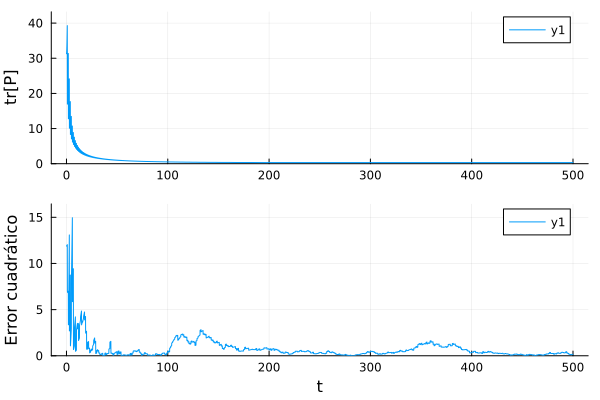

In [22]:

plot_error(t, x, z_true, P)

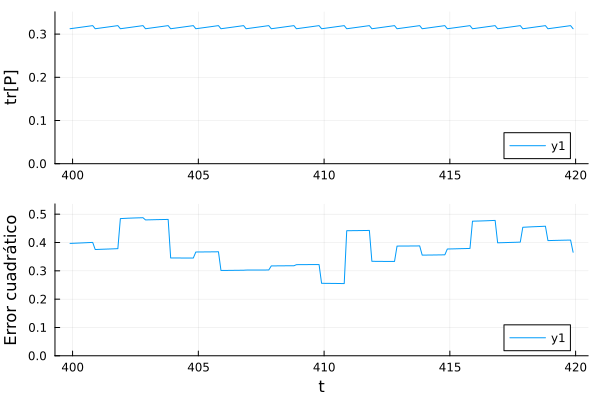

In [23]:
k1 = 4000
k2 = 4200
plot_error(t[k1:k2], x[:,k1:k2], z_true[:,k1:k2], P[:,:,k1:k2])

In [ ]:
function kalman_correct(x_prior, z, P_prior, K, GPS=true, mag=true)
    if GPS && mag
      H2 = H
      z2 = z
      R2 = R
    elseif mag
      H2 = H[3,:]'
      z2 = z[3]
      R2 = R[3,3]
    else
      H2 = H[1:2, :]
      z2 = z[1:2]
      R2 = R[1:2,1:2]
    end  
    K = P_prior*H2'*inv(H2*P_prior*H2'+R2)
    x_est = x_prior + K*(z2-H2*x_prior)
    P_est = (I-K*H2)*P_prior
    return x_est, P_est, K
  end
  
  function kalman(t, tasa_GPS, u, z, Q, R, gps, mag)
      x, P, K = kalman_initialize(t, z, R)
      K = zeros(size(t))
      for k in 2:length(t)
          x_est, P_est = kalman_predict(x[:,k-1], u[:,k], P[:,:,k-1], Q)
          if k%tasa_GPS == 0
              x_est, P_est, K_k = kalman_correct(x_est, z[:,k], P_est, R, gps[k], mag[k])
            K[k] = norm(K_k)
          end
          x[:,k] = x_est
          P[:,:,k] = P_est
      end
      return x, P, K
  end
  
  function kalman_predict(x, u, P, Q)
    B = B_matrix(x[5])
    x_est = A*x + B*u
    P_est = A*P*A' + B*Q*B'
    return x_est, P_est
end

  function kalman_initialize(t, z, R)
    N = length(t)
    x = zeros(5, N)
    x[1:2:5,1] = z[:,1]
    P = zeros(5, 5, N)
    P[:,:,1] = diagm([R[1,1]^2,(R[1,1]*fs2)^2,R[2,2]^2,(R[2,2]*fs2)^2,2pi])
    K = zeros(5, 3, N)
    return x, P, K
end

kalman_initialize (generic function with 2 methods)

In [65]:
gps_sig = ones(size(t)) .|> Bool
mag_sig = ones(size(t)) .|> Bool
gps_sig[3001:4000] = zeros(1000) .|> Bool

1000-element BitVector:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0

In [66]:
#| output: false

Q = [(err_IMU_x)^2 0 0; 0 (err_IMU_x)^2 0; 0 0 (err_IMU_θ)^2]
R = [err_GPS^2 0 0; 0 err_GPS^2 0; 0 0 err_MAG^2]

dist_ruido_IMU = MvNormal([0,0,0], Q)
dist_ruido_GPS = MvNormal([0,0,0], R)

u_noise = hcat([rand(dist_ruido_IMU) for ti in t]...)
z_noise = hcat([rand(dist_ruido_GPS) for ti in t]...)

u_true = hcat([circular_IMU(20, 2*pi/T, ti) for ti in t]...)
z_true = hcat([circular_GPS(20, 2*pi/T, ti) for ti in t]...)

u = u_true + u_noise
z = z_true + z_noise

x, P2, K2 = kalman(t, 10, u, z, Q, R, gps_sig, mag_sig)

()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7
()
1.5551418366801118e-7


([19.34614215897161 19.346119851348885 … 19.94996247292275 19.950499369109938; 0.0 -0.0004461524544820676 … 0.005438838776494496 0.005299084967251085; … ; 0.0 -0.00014165431251806913 … 0.2615666344279911 0.2623232923766472; 1.570283476723263 1.571456629111551 … 7.852661931752863 7.853835199901739], [39.0625 0.0 … 0.0 0.0; 0.0 39.0625 … 0.0 0.0; … ; 0.0 0.0 … 39.0625 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 39.45312500016 3.9062500032 … 2.929752672094091e-28 0.0; 3.9062500032 39.062500064 … -4.0921018160818156e-27 0.0; … ; 2.9274784435890066e-28 5.563218947493499e-27 … 39.062500064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 40.6250000016 7.8125000128 … -7.012963836232524e-29 0.0; 7.8125000128 39.062500127999996 … -5.711112357581009e-27 0.0; … ; 9.346958772904156e-28 8.172271131782737e-27 … 39.062500127999996 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.1613407833956804 0.0020740643190168815 … 1.8665810160876586e-22 0.0; 0.0020740643190168815 5.545386495877395e-5 … 3.59322811117798e-24 0.

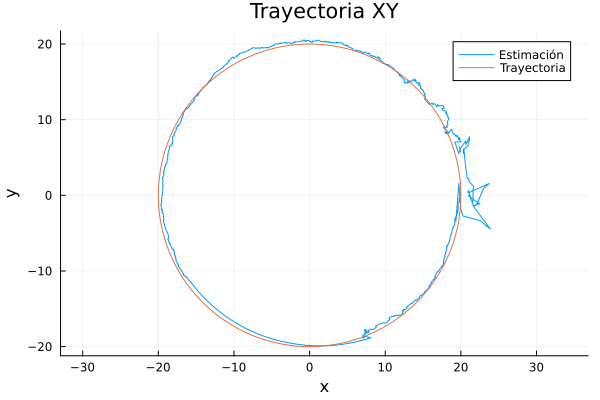

In [69]:

trayectoria_xy(x, z_true)

In [70]:

x, P2, K2 = kalman(t, 10, u, z, Q, R, mag_sig, gps_sig)

([19.34614215897161 19.346119851348885 … 19.99328045085733 19.993871292556964; 0.0 -0.0004461524544820676 … 0.005978293900963865 0.005838540091720454; … ; 0.0 -0.00014165431251806913 … 0.2623050866881833 0.2630617446368394; 1.570283476723263 1.571456629111551 … 7.852661931752863 7.853835199901739], [39.0625 0.0 … 0.0 0.0; 0.0 39.0625 … 0.0 0.0; … ; 0.0 0.0 … 39.0625 0.0; 0.0 0.0 … 0.0 6.283185307179586;;; 39.45312500016 3.9062500032 … 2.929752672094091e-28 0.0; 3.9062500032 39.062500064 … -4.0921018160818156e-27 0.0; … ; 2.9274784435890066e-28 5.563218947493499e-27 … 39.062500064 0.0; 0.0 0.0 … 0.0 6.283185334595154;;; 40.6250000016 7.8125000128 … -7.012963836232524e-29 0.0; 7.8125000128 39.062500127999996 … -5.711112357581009e-27 0.0; … ; 9.346958772904156e-28 8.172271131782737e-27 … 39.062500127999996 0.0; 0.0 0.0 … 0.0 6.283185362010721;;; … ;;; 0.15972723750735476 0.00202037050907998 … -3.244480209526759e-22 0.0; 0.0020203705090799796 5.085414131495572e-5 … -5.8511729223730434e-24 

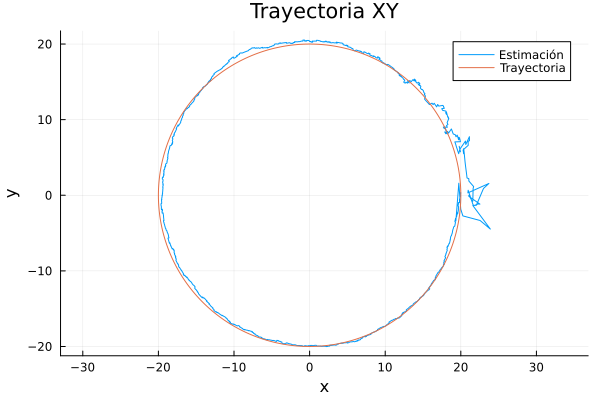

In [71]:

trayectoria_xy(x, z_true)

5001-element Vector{Float64}:
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 ⋮
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0
 0.0